In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
from scipy.ndimage import binary_fill_holes, label, generate_binary_structure, convolve
from scipy.stats import linregress
import matplotlib.colors as mcolors

set_matplotlib_formats('png', dpi=150)

In [29]:
# --- Config ---
lattice_height = 5000
lattice_width = 5000
fill_probability = 0.405
feature_area_threshold = 5000
convolution_structure = generate_binary_structure(rank=2, connectivity=1)  # 4-connected

In [26]:
# --- Generate random lattice ---
def generate_lattice(width, height, prob):
    return np.random.rand(height, width) < prob

# --- Filter small features ---
def filter_features_over_threshold(labeled_features, num_features, threshold):
    counts = np.bincount(labeled_features.ravel())
    valid = counts > threshold
    valid[0] = False  # background stays 0
    mask = valid[labeled_features]
    filtered_labels, new_count = label(mask, structure=convolution_structure)
    return filtered_labels, new_count

# --- Check if a feature touches image border ---
def touches_edge(coords, shape):
    return (
        (coords[:, 0] == 0).any() or
        (coords[:, 0] == shape[0] - 1).any() or
        (coords[:, 1] == 0).any() or
        (coords[:, 1] == shape[1] - 1).any()
    )

# --- Compute perimeter in terms of pixel sides (4-connected) ---
def compute_perimeter(mask):
    kernel = np.array([[0, 1, 0],
                       [1, 0, 1],
                       [0, 1, 0]])
    neighbors = convolve(mask.astype(np.uint8), kernel, mode='constant', cval=0)
    return np.sum(mask * (4 - neighbors))

def compute_area_and_perimeter(mask):
    """
    Computes the area and pixel-side perimeter (4-connected) of a single cloud.
    Assumes the mask contains exactly one connected feature.
    
    Parameters:
        mask : 2D boolean array (full-size image, exactly one blob)
    
    Returns:
        area : int
        perimeter : int
    """
    # Find bounding box via nonzero indices (very fast)
    rows, cols = np.where(mask)
    if rows.size == 0:
        return 0, 0  # Edge case: empty mask
    
    row_min, row_max = rows.min(), rows.max() + 1
    col_min, col_max = cols.min(), cols.max() + 1
    cropped = mask[row_min:row_max, col_min:col_max]

    # Area = number of True pixels
    area = np.count_nonzero(cropped)

    # Perimeter = sum of 4 - number of 4-connected neighbors
    kernel = np.array([[0, 1, 0],
                       [1, 0, 1],
                       [0, 1, 0]])
    neighbors = convolve(cropped.astype(np.uint8), kernel, mode='constant', cval=0)
    perimeter = np.sum(cropped * (4 - neighbors))

    return area, perimeter

def count_edge_contacts(coords, shape):
    """
    Returns the number of pixels in the feature that touch each image edge.
    
    Parameters:
        coords : np.ndarray of shape (N, 2)
            Coordinates of pixels in the feature.
        shape : tuple
            Shape of the full image (height, width)
    
    Returns:
        edge_counts : np.ndarray of shape (4,)
            Number of pixels touching [left, top, right, bottom] edges respectively.
    """
    rows, cols = coords[:, 0], coords[:, 1]
    height, width = shape

    left_count   = np.sum(cols == 0)
    top_count    = np.sum(rows == 0)
    right_count  = np.sum(cols == width - 1)
    bottom_count = np.sum(rows == height - 1)

    return np.array([left_count, top_count, right_count, bottom_count])

def interpret_edge_touch(edge_counts):
    """
    Interprets how a cloud touches the edges of the image.

    Parameters:
        edge_counts : np.ndarray of shape (4,)
            Number of pixels touching [left, top, right, bottom] edges.

    Returns:
        int:
            0  → no edge touched
            1  → exactly one edge touched
            2  → exactly two adjacent edges touched
            -1 → otherwise (non-adjacent pairs or >= 3 edges touched)
    """
    # Find which edges are touched
    left = edge_counts[0] > 0
    top = edge_counts[1] > 0
    right = edge_counts[2] > 0
    bottom = edge_counts[3] > 0

    num_touched = np.count_nonzero(edge_counts)

    if num_touched == 0:
        return 0
    elif num_touched == 1:
        return 1
    elif num_touched == 2:
        if (left and right) or (top and bottom):
            return -1
        else: 
            return 2
    else:
        return -1

def plot_loglog_with_fit(areas, perims, title):
    log_area = np.log(areas)
    log_perim = np.log(perims)
    slope, intercept, r_value, _, _ = linregress(log_area, log_perim)
    D = 2 * slope
    r2 = r_value ** 2

    plt.figure(figsize=(6, 5))
    plt.loglog(areas, perims, 'o', markersize=2, alpha=0.6, label='Data')
    plt.loglog(areas, np.exp(intercept) * areas**slope, 'r--',
               label=f'Fit: slope={slope:.4f} → D={D:.4f}')
    plt.xlabel('Area (log scale)')
    plt.ylabel('Perimeter (log scale)')
    plt.title(f'{title}\nFractal Dimension ≈ {D:.4f}, R² = {r2:.4f}')
    plt.legend()
    plt.grid(True, which='both', ls='--', lw=0.5)
    plt.tight_layout()
    plt.show()

    print(f"{title}")
    print(f"  Slope (log-log): {slope:.4f}")
    print(f"  Estimated fractal dimension D: {D:.4f}")
    print(f"  R²: {r2:.4f}\n")

def compute_loglog_stats(areas, perims):
    if len(areas) == 0 or len(perims) == 0:
        return None
    log_area = np.log(areas)
    log_perim = np.log(perims)
    slope, intercept, r_value, _, _ = linregress(log_area, log_perim)
    D = 2 * slope
    r2 = r_value ** 2
    return D, r2

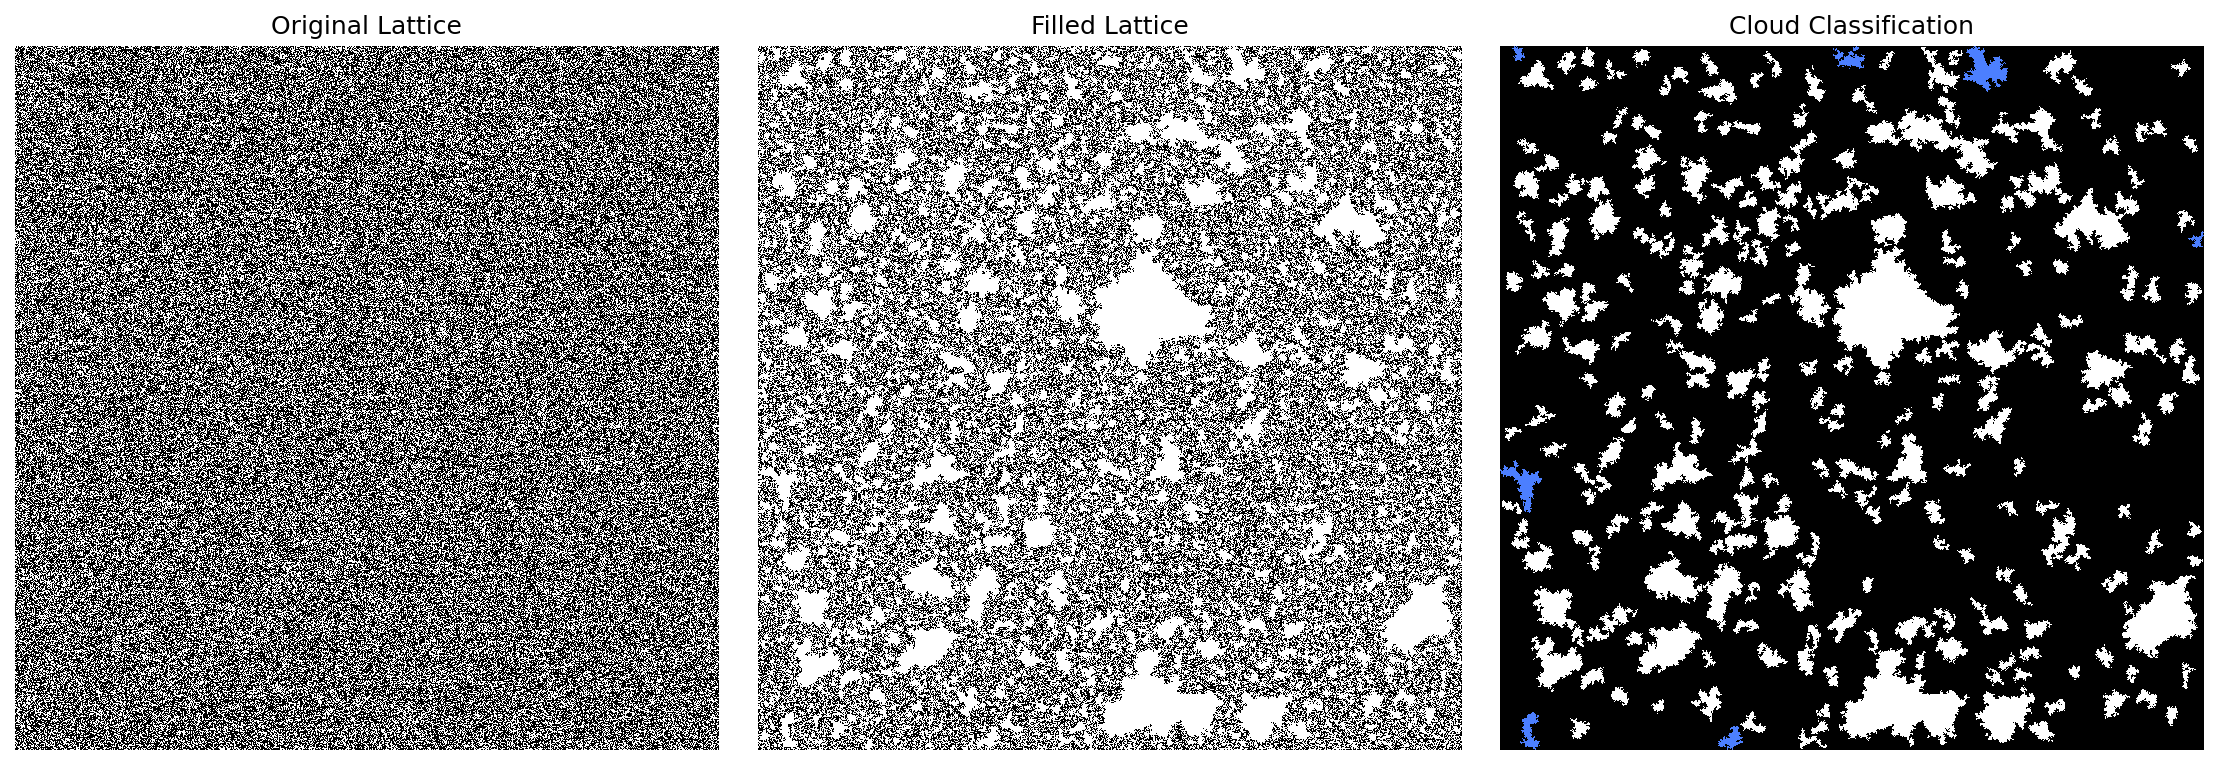


=== Cloud Classification Summary ===
Total labeled features: 248
  Internal (valid):  241 (97.18%)
  Mirrored (valid):  7 (2.82%)
  Discarded:          0 (0.00%)


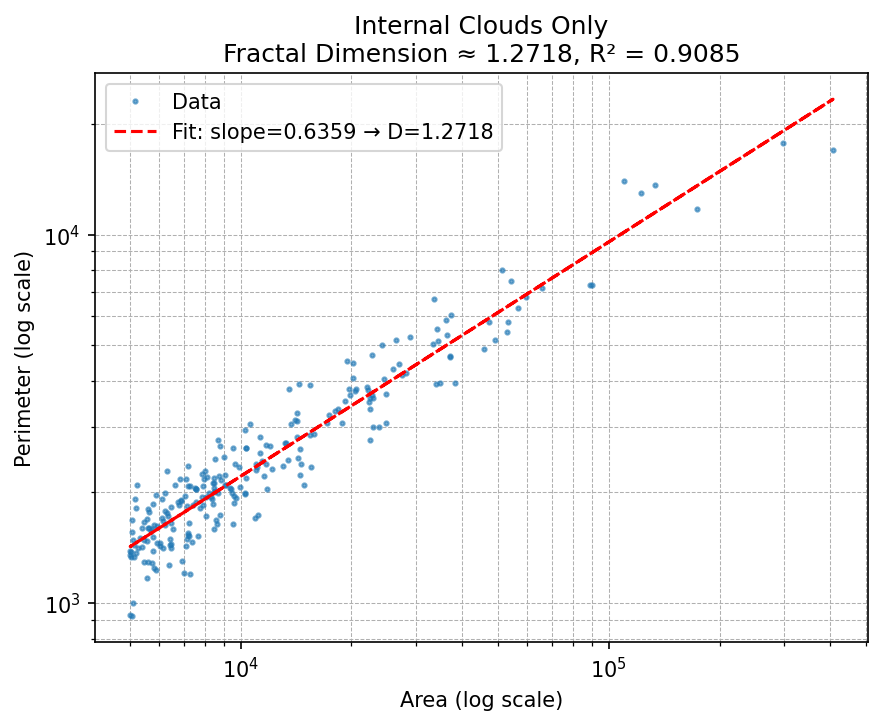

Internal Clouds Only
  Slope (log-log): 0.6359
  Estimated fractal dimension D: 1.2718
  R²: 0.9085



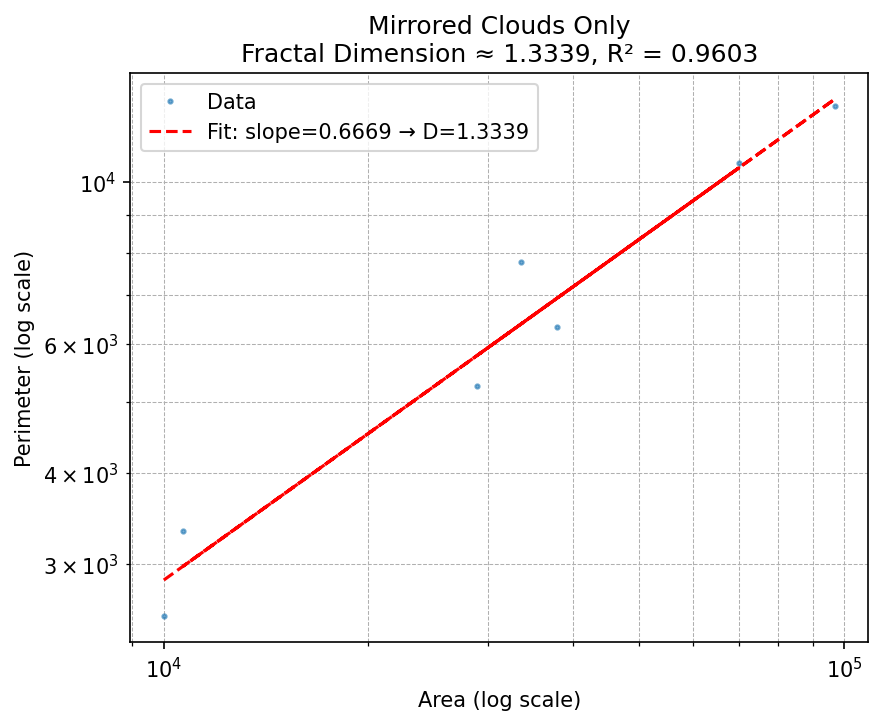

Mirrored Clouds Only
  Slope (log-log): 0.6669
  Estimated fractal dimension D: 1.3339
  R²: 0.9603



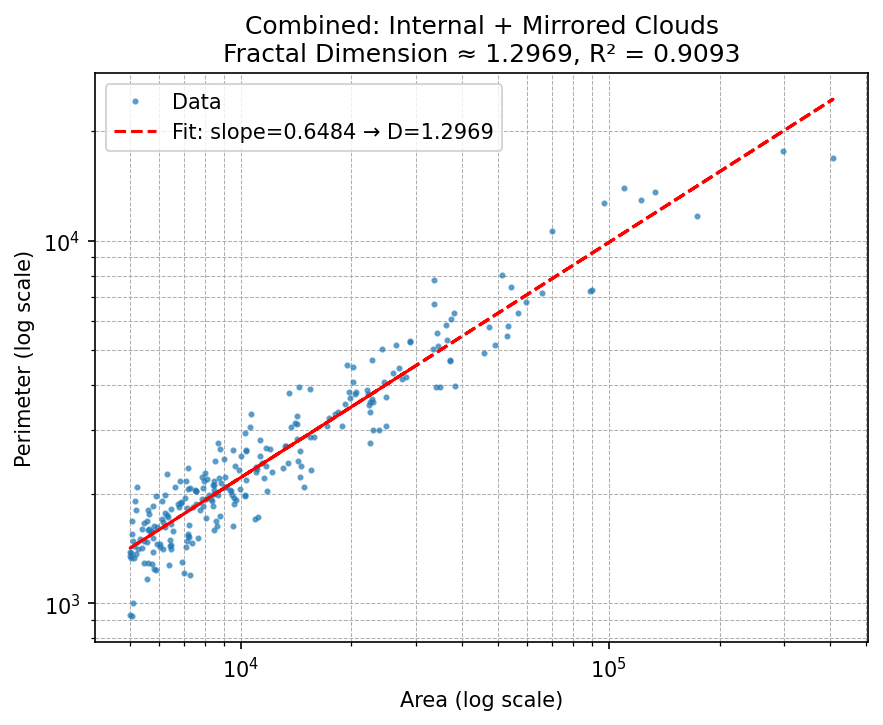

Combined: Internal + Mirrored Clouds
  Slope (log-log): 0.6484
  Estimated fractal dimension D: 1.2969
  R²: 0.9093



In [31]:
# --- Main pipeline ---
lattice = generate_lattice(lattice_width, lattice_height, fill_probability)
filled_lattice = binary_fill_holes(lattice, structure=convolution_structure)
labeled_features, num_features = label(filled_lattice, structure=convolution_structure)
labeled_features, num_features = filter_features_over_threshold(labeled_features, num_features, feature_area_threshold)

# --- Prepare containers ---
areas_full, perims_full = [], []
areas_mirror, perims_mirror = [], []
mask_internal = np.zeros_like(labeled_features, dtype=bool)
mask_mirrored = np.zeros_like(labeled_features, dtype=bool)
mask_discarded = np.zeros_like(labeled_features, dtype=bool)
internal_ids, mirrored_ids = [], []

# --- Feature analysis loop ---
for label_id in range(1, num_features + 1):
    mask = labeled_features == label_id
    coords = np.argwhere(mask)
    edge_counts = count_edge_contacts(coords, mask.shape)
    valid_edges_hit = interpret_edge_touch(edge_counts)

    if valid_edges_hit == 0:
        # Fully internal feature
        area, perimeter = compute_area_and_perimeter(mask)
        areas_full.append(area)
        perims_full.append(perimeter)
        mask_internal |= mask
        internal_ids.append(label_id)

    elif valid_edges_hit == 1 or valid_edges_hit == 2:
        # Eligible for mirroring
        area, perimeter = compute_area_and_perimeter(mask)
        mirrored_area = area * valid_edges_hit * 2
        mirrored_perimeter = (perimeter - np.sum(edge_counts)) * valid_edges_hit * 2
        areas_mirror.append(mirrored_area)
        perims_mirror.append(mirrored_perimeter)
        mask_mirrored |= mask
        mirrored_ids.append(label_id)
    else:
        mask_discarded |= mask  # not used in stats but visualized

# --- Convert to arrays ---
areas_full = np.array(areas_full)
perims_full = np.array(perims_full)
areas_mirror = np.array(areas_mirror)
perims_mirror = np.array(perims_mirror)

# --- Visualization of classification ---
visual = np.zeros((*labeled_features.shape, 3), dtype=np.float32)
visual[mask_internal] = [1.0, 1.0, 1.0]   # white = internal
visual[mask_mirrored] = [0.3, 0.5, 1.0]   # blue = mirrored
visual[mask_discarded] = [0.3, 0.3, 0.3]  # gray = discarded

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Original Lattice")
plt.imshow(lattice, cmap='gray', interpolation='nearest')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Filled Lattice")
plt.imshow(filled_lattice, cmap='gray', interpolation='nearest')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Cloud Classification")
plt.imshow(visual, interpolation='nearest')
plt.axis('off')

plt.tight_layout()
plt.show()

# --- Ratio summary ---
n_internal = len(internal_ids)
n_mirrored = len(mirrored_ids)
n_total = n_internal + n_mirrored
n_discarded = num_features - n_total

print(f"\n=== Cloud Classification Summary ===")
print(f"Total labeled features: {num_features}")
print(f"  Internal (valid):  {n_internal} ({n_internal / num_features:.2%})")
print(f"  Mirrored (valid):  {n_mirrored} ({n_mirrored / num_features:.2%})")
print(f"  Discarded:          {n_discarded} ({n_discarded / num_features:.2%})")

# --- Log-log slope plots ---
if len(areas_full) > 0:
    plot_loglog_with_fit(areas_full, perims_full, "Internal Clouds Only")

if len(areas_mirror) > 0:
    plot_loglog_with_fit(areas_mirror, perims_mirror, "Mirrored Clouds Only")

if len(areas_full) > 0 and len(areas_mirror) > 0:
    plot_loglog_with_fit(
        np.concatenate([areas_full, areas_mirror]),
        np.concatenate([perims_full, perims_mirror]),
        "Combined: Internal + Mirrored Clouds"
    )


In [30]:
# Store stats for all runs
results = []

for i in range(1, 21):  # 20 runs
    print(f"\n--- Run {i} ---")

    # Run your main pipeline here (you can inline it or call a function)
    lattice = generate_lattice(lattice_width, lattice_height, fill_probability)
    filled_lattice = binary_fill_holes(lattice, structure=convolution_structure)
    labeled_features, num_features = label(filled_lattice, structure=convolution_structure)
    labeled_features, num_features = filter_features_over_threshold(labeled_features, num_features, feature_area_threshold)

    areas_full, perims_full = [], []
    areas_mirror, perims_mirror = [], []

    for label_id in range(1, num_features + 1):
        mask = (labeled_features == label_id)
        coords = np.argwhere(mask)
        edge_counts = count_edge_contacts(coords, mask.shape)
        edge_case = interpret_edge_touch(edge_counts)

        if edge_case == 0:
            area, perimeter = compute_area_and_perimeter(mask)
            areas_full.append(area)
            perims_full.append(perimeter)
        elif edge_case == 1 or edge_case == 2:
            area, perimeter = compute_area_and_perimeter(mask)
            mirrored_area = area * valid_edges_hit * 2
            mirrored_perimeter = (perimeter - np.sum(edge_counts)) * valid_edges_hit * 2
            areas_mirror.append(mirrored_area)
            perims_mirror.append(mirrored_perimeter)

    # Convert to arrays
    areas_full = np.array(areas_full)
    perims_full = np.array(perims_full)
    areas_mirror = np.array(areas_mirror)
    perims_mirror = np.array(perims_mirror)

    # Compute stats
    stats_internal = compute_loglog_stats(areas_full, perims_full)
    stats_mirrored = compute_loglog_stats(areas_mirror, perims_mirror)
    stats_combined = compute_loglog_stats(
        np.concatenate([areas_full, areas_mirror]),
        np.concatenate([perims_full, perims_mirror])
    ) if len(areas_full) and len(areas_mirror) else None

    # Store results
    results.append({
        "run": i,
        "internal_count": len(areas_full),
        "mirrored_count": len(areas_mirror),
        "internal_D": stats_internal[0] if stats_internal else None,
        "internal_R2": stats_internal[1] if stats_internal else None,
        "mirrored_D": stats_mirrored[0] if stats_mirrored else None,
        "mirrored_R2": stats_mirrored[1] if stats_mirrored else None,
        "combined_D": stats_combined[0] if stats_combined else None,
        "combined_R2": stats_combined[1] if stats_combined else None,
    })

# --- Print Summary ---
print("\n=== Summary of All Runs ===")
for r in results:
    print(f"Run {r['run']:2d} | Internal: {r['internal_count']:4d}, Mirrored: {r['mirrored_count']:4d} | "
          f"D_internal = {r['internal_D']:.4f}, R² = {r['internal_R2']:.4f} | "
          f"D_mirrored = {r['mirrored_D']:.4f}, R² = {r['mirrored_R2']:.4f} | "
          f"D_combined = {r['combined_D']:.4f}, R² = {r['combined_R2']:.4f}")


--- Run 1 ---

--- Run 2 ---

--- Run 3 ---

--- Run 4 ---

--- Run 5 ---

--- Run 6 ---

--- Run 7 ---

--- Run 8 ---

--- Run 9 ---

--- Run 10 ---

--- Run 11 ---

--- Run 12 ---

--- Run 13 ---

--- Run 14 ---

--- Run 15 ---

--- Run 16 ---

--- Run 17 ---

--- Run 18 ---

--- Run 19 ---

--- Run 20 ---

=== Summary of All Runs ===
Run  1 | Internal:  223, Mirrored:   10 | D_internal = 1.3333, R² = 0.8832 | D_mirrored = 1.3828, R² = 0.9039 | D_combined = 1.3485, R² = 0.8816
Run  2 | Internal:  241, Mirrored:    5 | D_internal = 1.2832, R² = 0.8960 | D_mirrored = 1.5219, R² = 0.9937 | D_combined = 1.3214, R² = 0.9027
Run  3 | Internal:  237, Mirrored:   13 | D_internal = 1.3145, R² = 0.9128 | D_mirrored = 1.2827, R² = 0.9578 | D_combined = 1.3318, R² = 0.9180
Run  4 | Internal:  218, Mirrored:   11 | D_internal = 1.3059, R² = 0.9001 | D_mirrored = 1.5629, R² = 0.8874 | D_combined = 1.3261, R² = 0.8986
Run  5 | Internal:  229, Mirrored:    8 | D_internal = 1.3021, R² = 0.9098 | D_m